<a href="https://colab.research.google.com/github/delhian/NLP_course/blob/master/screencasts/basic_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets > /dev/null
!pip install tokenizers > /dev/null
!pip install transformers > /dev/null

### importing

In [ ]:
import random
import collections
import os

from sklearn.model_selection import KFold

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd

import datasets

from tqdm.auto import tqdm

import matplotlib.pyplot as plt

In [ ]:
text_dataset = datasets.load_dataset("imdb")

Downloading:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/84.1M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a. Subsequent calls will reuse this data.


In [ ]:
from tokenizers import SentencePieceBPETokenizer 

In [ ]:
special_tokens = ["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"]

In [ ]:
tokenizer = SentencePieceBPETokenizer(
    unk_token="[UNK]",
    replacement="▁",
    add_prefix_space=True,
    dropout=0.9,
    fuse_unk=False
)

In [ ]:
def batch_iterator():
    batch_length = 1000
    for i in range(0, len(text_dataset["train"]), batch_length):
        yield text_dataset["train"][i : i + batch_length]["text"]

tokenizer.train_from_iterator(batch_iterator(),
                              vocab_size=30000,
                              min_frequency=2,
                              show_progress=True,
                              special_tokens=special_tokens
                              )

In [ ]:
tokenizer.save_model('./')

['./vocab.json', './merges.txt']

In [ ]:
tokenizer = SentencePieceBPETokenizer('./vocab.json', './merges.txt', unk_token="[UNK]",
                                      replacement="▁", add_prefix_space=True,
                                      fuse_unk=False)
encoded = tokenizer.encode('Some asdonsd uncommn phrase')
encoded.tokens

['▁Some', '▁as', 'd', 'ons', 'd', '▁uncom', 'm', 'n', '▁phrase']

In [ ]:
l = float('-inf')
l = list()
for text in tqdm(text_dataset['train']['text']):
    l.append(len(tokenizer.encode(text).ids))

  0%|          | 0/25000 [00:00<?, ?it/s]

697.0


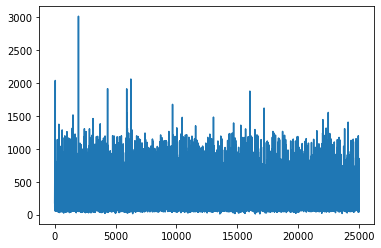

In [ ]:
print(pd.Series(l).quantile(0.95))
max_len = pd.Series(l).quantile(0.95)
pd.Series(l).plot();

In [ ]:
class CustomDataset:
  def __init__(self, data, targets, tokenizer, max_len=max_len):
    self.data = data
    self.targets = targets
    self.tokenizer = tokenizer

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    text = self.data[idx]
    label = self.targets[idx]

    input_ids = np.zeros((int(max_len),))
    row = self.tokenizer.encode(text).ids
    for j, id in enumerate(row):
      if j < max_len:
        input_ids[j] = id
    
    return {
        'text': torch.tensor(input_ids, dtype=torch.long),
        'label': torch.tensor(label, dtype=torch.long)
    }

In [ ]:
train_dataset = CustomDataset(text_dataset['train']['text'], text_dataset['train']['label'], tokenizer)
test_dataset = CustomDataset(text_dataset['test']['text'], text_dataset['test']['label'], tokenizer)

In [ ]:
class ConvNeuralNet(nn.Module):
    def __init__(self, input_dim, embed_size,
                 do_rate1=0.5, n_classes=2):
        super(ConvNeuralNet, self).__init__()

        self.vocab_size = input_dim
        self.embedding_size = embed_size
        self.kernel_num = 200
        self.kernels_sizes = [2, 6, 10]
        
        self.embedding = nn.Embedding(self.vocab_size, embed_size)
        self.convs = nn.ModuleList([nn.Conv2d(1, self.kernel_num, (K, embed_size)) for K in self.kernels_sizes])
        self.dropout = nn.Dropout2d(do_rate1)
        self.fc1 = nn.Linear(len(self.kernels_sizes) * self.kernel_num, n_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)
        
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs]
        
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
        
        x = torch.cat(x, 1)
        
        x = self.dropout(x)
        logit = self.fc1(x)
        return logit

In [ ]:
def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    start_time = time.time()

    for idx, batch in enumerate(tqdm(dataloader)):
        text = batch['text'].to(device)
        label = batch['label'].to(device)
        optimizer.zero_grad()
        predited_label = model(text)
        loss = criterion(predited_label, label)
        loss.backward()
        optimizer.step()
        predited_label = predited_label.detach().cpu().numpy()
        label = label.to('cpu').numpy()
        total_acc += accuracy(predited_label, label)
        total_count += len(label)
    elapsed = time.time() - start_time
    print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
    total_acc, total_count = 0, 0
    start_time = time.time()

In [ ]:
def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, batch in enumerate(dataloader):
            text = batch['text'].to(device)
            label = batch['label'].to(device)
            predited_label = model(text)
            loss = criterion(predited_label, label)
            predited_label = predited_label.detach().cpu().numpy()
            label = label.to('cpu').numpy()
            total_acc += accuracy(predited_label, label)
            total_count += len(label)
    return total_acc/total_count

In [ ]:
def accuracy(probs, targets):
    outputs = np.argmax(probs, axis=1)
    return np.sum(outputs == targets)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else  torch.device('cpu')
device

device(type='cuda')

In [ ]:
from torch.utils.data.dataset import random_split
import time

# гиперпараметры
EPOCHS = 7
LR = 3e-4 
BATCH_SIZE = 32

model = NeuralNet(tokenizer.get_vocab_size(), 300).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
total_accu = None

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,
                              shuffle=True)


for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)

  0%|          | 0/782 [00:00<?, ?it/s]

| epoch   1 |   781/  782 batches | accuracy    0.452
-----------------------------------------------------------
| end of epoch   1 | time: 203.29s | valid accuracy    0.575 
-----------------------------------------------------------


  0%|          | 0/782 [00:00<?, ?it/s]

| epoch   2 |   781/  782 batches | accuracy    0.538
-----------------------------------------------------------
| end of epoch   2 | time: 206.58s | valid accuracy    0.757 
-----------------------------------------------------------


  0%|          | 0/782 [00:00<?, ?it/s]

| epoch   3 |   781/  782 batches | accuracy    0.575
-----------------------------------------------------------
| end of epoch   3 | time: 206.60s | valid accuracy    0.787 
-----------------------------------------------------------


  0%|          | 0/782 [00:00<?, ?it/s]

| epoch   4 |   781/  782 batches | accuracy    0.593
-----------------------------------------------------------
| end of epoch   4 | time: 206.60s | valid accuracy    0.828 
-----------------------------------------------------------


  0%|          | 0/782 [00:00<?, ?it/s]

| epoch   5 |   781/  782 batches | accuracy    0.594
-----------------------------------------------------------
| end of epoch   5 | time: 206.90s | valid accuracy    0.850 
-----------------------------------------------------------


  0%|          | 0/782 [00:00<?, ?it/s]

| epoch   6 |   781/  782 batches | accuracy    0.602
-----------------------------------------------------------
| end of epoch   6 | time: 206.87s | valid accuracy    0.849 
-----------------------------------------------------------


  0%|          | 0/782 [00:00<?, ?it/s]

| epoch   7 |   781/  782 batches | accuracy    0.610
-----------------------------------------------------------
| end of epoch   7 | time: 207.28s | valid accuracy    0.860 
-----------------------------------------------------------
